<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/035_ANOVA_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 ANOVA: Jak porównać więcej niż dwie grupy?

**Problem:**
T-test działa świetnie dla 2 grup (A vs B).
Jeśli masz 3 grupy (A, B, C) i zrobisz 3 osobne testy, to ryzyko, że "przypadkiem" znajdziesz różnicę, drastycznie rośnie (Problem wielokrotnych porównań).

**Rozwiązanie: One-Way ANOVA (Jednoczynnikowa Analiza Wariancji).**
Testuje hipotezę zerową: *"Średnie we WSZYSTKICH grupach są takie same"*.

*   Jeśli **p < 0.05** -> Przynajmniej jedna grupa różni się od reszty.
*   Ale uwaga: ANOVA nie mówi **która**. Do tego potrzebujemy testu "post-hoc" (Tukey HSD).

### Scenariusz: Testy Strony WWW
Mamy 3 wersje sklepu internetowego:
1.  **Control:** Stara wersja.
2.  **Design A:** Nowe kolory.
3.  **Design B:** Nowy układ przycisków.

Chcemy sprawdzić, czy któraś wersja generuje większą sprzedaż.

--- DANE Z EKSPERYMENTU ---


,Sprzedaz,Grupa
135,138.249016,Design B
64,115.187887,Design A
51,97.223766,Design A
56,90.411737,Design A
146,96.445739,Design B


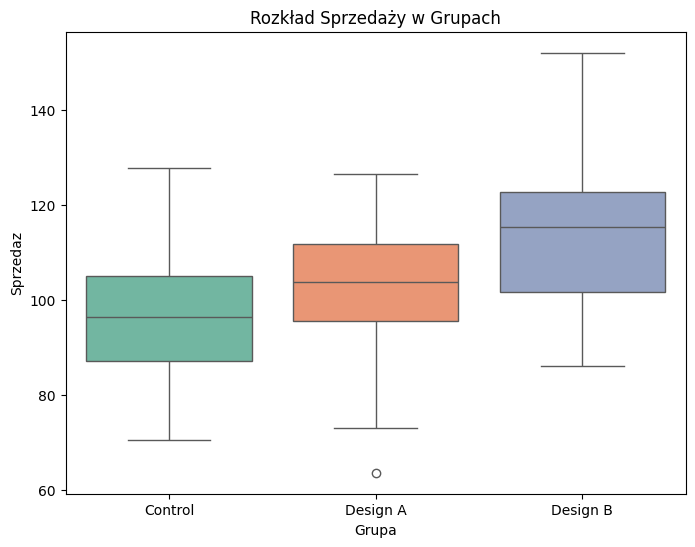

In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# 1. GENERUJEMY DANE (Symulacja Sprzedaży)
np.random.seed(42)
n = 50 # próbek w każdej grupie

# Control: Średnia sprzedaż 100 zł
control = np.random.normal(loc=100, scale=15, size=n)

# Design A: Średnia 103 zł (Minimalnie lepiej, ale czy istotnie?)
design_a = np.random.normal(loc=103, scale=15, size=n)

# Design B: Średnia 115 zł (Wyraźnie lepiej)
design_b = np.random.normal(loc=115, scale=15, size=n)

# Łączymy w DataFrame
df = pd.DataFrame({
    'Sprzedaz': np.concatenate([control, design_a, design_b]),
    'Grupa': ['Control']*n + ['Design A']*n + ['Design B']*n
})

print("--- DANE Z EKSPERYMENTU ---")
display(df.sample(5))

# Wizualizacja (Boxplot prawdę ci powie)
plt.figure(figsize=(8, 6))

# POPRAWKA: Dodaliśmy hue='Grupa' i legend=False
sns.boxplot(x='Grupa', y='Sprzedaz', data=df, hue='Grupa', palette='Set2', legend=False)

plt.title("Rozkład Sprzedaży w Grupach")
plt.show()

## Krok 1: Test ANOVA (F-Test)

ANOVA liczy tzw. **Statystykę F**.
$$ F = \frac{\text{Wariancja MIĘDZY grupami}}{\text{Wariancja WEWNĄTRZ grup}} $$

*   **Licznik (Między):** Jak bardzo "rozjechane" są średnie grup (A vs B vs C). Chcemy, żeby był duży.
*   **Mianownik (Wewnątrz):** Jak bardzo "rozrzuceni" są ludzie wewnątrz jednej grupy (szum). Chcemy, żeby był mały.

Jeśli F jest duże -> Różnica między grupami jest ważniejsza niż szum.

In [4]:
# Wykonujemy ANOVA
# f_oneway bierze tablice z danymi
f_stat, p_value = stats.f_oneway(control, design_a, design_b)

print("--- WYNIKI ANOVA ---")
print(f"Statystyka F: {f_stat:.4f}")
print(f"P-value:      {p_value:.10f}")

print("-" * 30)
if p_value < 0.05:
    print("✅ WYNIK ISTOTNY: Odrzucamy hipotezę zerową.")
    print("Przynajmniej jedna grupa różni się od innych!")
    print("Ale która? ANOVA tego nie mówi.")
else:
    print("❌ BRAK RÓŻNIC: Wszystkie zmiany to tylko szum.")

--- WYNIKI ANOVA ---
Statystyka F: 20.2030
P-value:      0.0000000177
------------------------------
✅ WYNIK ISTOTNY: Odrzucamy hipotezę zerową.
Przynajmniej jedna grupa różni się od innych!
Ale która? ANOVA tego nie mówi.


## Krok 2: Detektywistyczna Robota (Post-hoc Tukey HSD)

Skoro ANOVA powiedziała "TAK, jest różnica", to musimy sprawdzić pary:
*   Control vs A
*   Control vs B
*   A vs B

Użyjemy testu **Tukey HSD (Honest Significant Difference)**. Jest on bardziej rygorystyczny niż zwykły T-test, żeby uniknąć błędów przy wielokrotnym sprawdzaniu.

--- SZCZEGÓŁOWE PORÓWNANIE (TUKEY) ---
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
 Control Design A   6.6488 0.0522 -0.0488 13.3464  False
 Control Design B  17.7928    0.0 11.0952 24.4904   True
Design A Design B   11.144 0.0004  4.4464 17.8415   True
--------------------------------------------------------


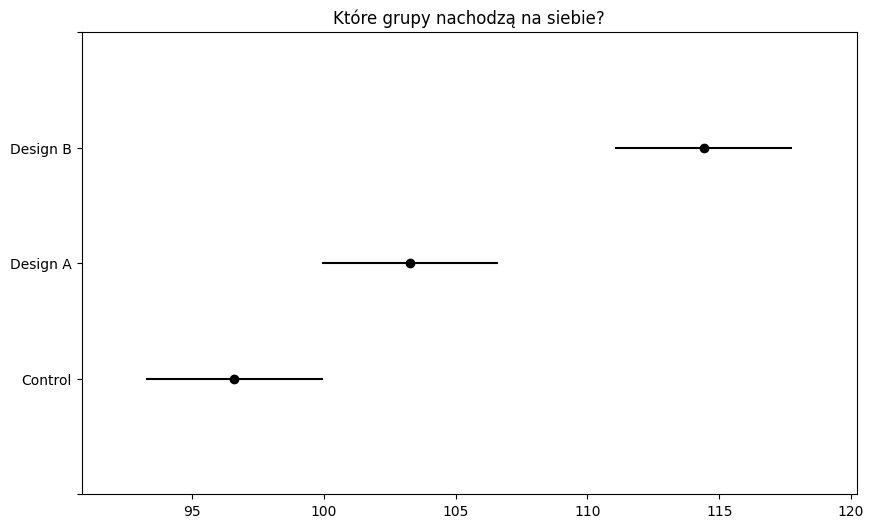

In [5]:
# Test Tukeya z biblioteki statsmodels
tukey = pairwise_tukeyhsd(endog=df['Sprzedaz'],   # Dane liczbowe
                          groups=df['Grupa'],     # Etykiety grup
                          alpha=0.05)             # Poziom istotności

print("--- SZCZEGÓŁOWE PORÓWNANIE (TUKEY) ---")
print(tukey)

# Wyświetlmy to na wykresie
fig = tukey.plot_simultaneous()
plt.title("Które grupy nachodzą na siebie?")
plt.show()

## 🧠 Analiza Wyników (Jak to czytać?)

Spójrz na tabelkę powyżej (kolumna `reject`):

1.  **Control vs Design A:** `reject = False`.
    *   Wniosek: Różnica między 100 zł a 103 zł jest **nieistotna statystycznie**. To mógł być przypadek. Szkoda pieniędzy na wdrażanie Designu A.

2.  **Control vs Design B:** `reject = True`.
    *   Wniosek: Różnica jest prawdziwa. Design B faktycznie działa lepiej.

3.  **Design A vs Design B:** `reject = True`.
    *   Wniosek: Design B jest też istotnie lepszy od Designu A.

**Zwycięzca:** Design B.

## 🧠 Podsumowanie: Sygnał kontra Szum

Dlaczego nie mogliśmy po prostu spojrzeć na średnie (100 vs 115) i uznać, że B jest lepsze?

**Tu jest haczyk (Wariancja Wewnątrz-grupowa).**
Wyobraź sobie, że w grupie Control jeden klient kupił towar za 1000 zł (tzw. Outlier). Średnia grupy skoczyłaby w górę.
ANOVA bierze to pod uwagę.
Test F sprawdza: *"Czy różnica między średnimi grup (Sygnał) jest wystarczająco duża, by przebić się przez rozrzut danych wewnątrz grup (Szum)?"*.

Dlatego ANOVA jest podstawowym narzędziem w **A/B Testing** w dużych firmach (Netflix, Uber, Amazon), gdzie małe zmiany mogą generować miliony, ale łatwo je pomylić z szumem.